In [1]:
import os
import pandas as pd
import seaborn as sns

In [2]:
def get_vtype_df(block_df, genes, samples):
    # select lof and deleterious missense variants
    block_df = block_df.loc[(block_df.lof==True)|(block_df.splice_lof==True)|((block_df.missense==True)&(block_df.del_score>4))]
    block_df["samples"] = block_df.samples.str.split(",")
    block_df = block_df.explode("samples")
    if len(samples)>0:
        block_df = block_df.loc[(block_df.samples.isin(samples)) & (block_df.gene.isin(genes))]
    else:
        block_df = block_df.loc[block_df.gene.isin(genes)]
    block_df["variant"] = block_df.gene + "_" + block_df.locus + "_" + block_df.alleles
    return block_df

def create_variant_df(annot_table_dir, genes, samples):
    vcfs_per_chrm = {
        "chr1": 97, "chr2": 71, "chr3": 56, "chr4": 39, "chr5": 43, "chr6": 48, 
        "chr7": 47, "chr8": 35, "chr9": 42, "chr10": 40, "chr11": 57, "chr12": 52, 
        "chr13": 18, "chr14": 30, "chr15": 34, "chr16": 47, "chr17": 56, "chr18": 16, 
        "chr19": 65, "chr20": 25, "chr21": 11, "chr22": 23, "chrX": 24, "chrY": 1
    }
    variant_df = pd.DataFrame()
    for chr_num in [f"chr{i}" for i in range(1,23)] + ["chrX", "chrY"]:
        chr_file_num = vcfs_per_chrm[chr_num]
        for filei in range(chr_file_num):
            block_file = os.path.join(annot_table_dir, f"{chr_num}", f"block_{filei}.tsv.gz")
            block_df = pd.read_csv(block_file, sep="\t", index_col=0)
            block_df = get_vtype_df(block_df, genes, samples)
            variant_df = pd.concat((variant_df, block_df))
    return variant_df

def prepare_npx_data(df0, df1, df2):
    df = df0.merge(df1, on="sample_names", how="outer", suffixes=("|0", "|1"))
    df2.columns = [f"{c}|2" if c!="sample_names" else "sample_names" for c in df2.columns]
    df = df.merge(df2, on="sample_names", how="outer")
    df = df.set_index("sample_names")
    df.index = df.index.astype(str)
    prefixes = [c+"|" for c in df0.columns if c!="sample_names"]
    grouper = [next(p for p in prefixes if c.startswith(p)) for c in df.columns]
    df_mean = df.groupby(grouper, axis=1).mean()
    df_mean.columns = [c.strip("|") for c in df_mean.columns]
    return df_mean

def variant_type_func(ser):
    vtype = "missense"
    if ser.lof==True:
        vtype="lof"
    elif ser.splice_lof==True:
        vtype="splice_lof"
    elif ser.splice==True:
        vtype="splice"
    return vtype

def variant_loc_func(ser, thresh=4508000):
    loc = int(ser.locus.split(":")[1])
    vloc="begin"
    if loc<=thresh:
        vloc="begin"
    elif loc>thresh:
        vloc="end"
    return vloc

def get_var_prot_phen_df(annot_df, protein_df, phenotype_df, gene):
    var_df = annot_df.loc[annot_df.gene==gene]
    protein_df = protein_df.loc[:, gene]
    var_prot_df = var_df.merge(protein_df, left_on="samples", right_index=True)
    var_prot_pheno_df = phenotype_df.merge(var_prot_df, left_on="sample_names", right_on="samples", how="right")
    return var_prot_pheno_df

# Variant

In [3]:
samples = ["1570890", "2075291", "3332768", "5088602", "5928853", "3814661", "2241303", "4364763", "4631997"]
genes = ["ASGR1", "MASP1", "GDF15", "TGFBI", "CDHR5", "LGALS3", "KRT19", "TSPAN1", "AZU1", "FUT8", "IL18RAP", "SULT1A1", "ARHGEF12", "DARS1", "MMP3", "NOS1", "HMOX2", "TGFBR2"]

annot_table_dir = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/exome_annot/data/annot_tables_vep109"
annot_df = create_variant_df(annot_table_dir, genes, [])

/tmp/ipykernel_25641/952636408.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_df["samples"] = block_df.samples.str.split(",")
/tmp/ipykernel_25641/952636408.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_df["samples"] = block_df.samples.str.split(",")
/tmp/ipykernel_25641/952636408.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

# Protein

In [4]:
df0 = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/proteomics/data/npx_inst0.csv.gz")
df1 = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/proteomics/data/npx_inst2.csv.gz")
df2 = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/proteomics/data/npx_inst3.csv.gz")

protein_df = prepare_npx_data(df0, df1, df2)

/tmp/ipykernel_25641/952636408.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_mean = df.groupby(grouper, axis=1).mean()


# Phenotype

In [5]:
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
phenotype_df = pd.read_csv(phenotype_file, usecols=["sample_names", "bmi", "bmi_prs", "bmi_residuals"], dtype={"sample_names": str, "bmi": float, "bmi_prs": float, "bmi_residuals":float})

# Variant protein phenotype info

In [6]:
hmox2_df = get_var_prot_phen_df(annot_df, protein_df, phenotype_df, "HMOX2")

In [7]:
hmox2_df["vtype"] = hmox2_df.apply(variant_type_func, axis=1)
hmox2_df["vloc"] = hmox2_df.apply(variant_loc_func, axis=1)

<AxesSubplot: xlabel='vtype', ylabel='HMOX2'>

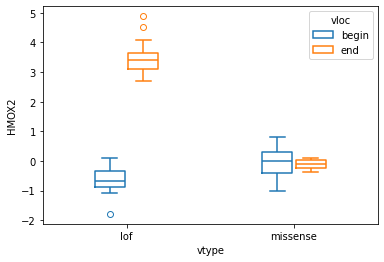

In [8]:
sns.boxplot(data=hmox2_df.loc[:, ["vloc", "vtype", "HMOX2"]].reset_index(drop=True), x="vtype", y="HMOX2", hue="vloc", fill=False, gap=.1, width=0.4)